# Libraries

In [1]:
from difflib import SequenceMatcher
import matplotlib.pyplot as plt
from benfordslaw import benfordslaw
from dateutil.parser import parse
from ast import literal_eval
import ast
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from pandas_profiling import ProfileReport


# Functions

In [2]:
def parse_date(date):
    '''
    Any string that resembels date will be converted into date type
    '''
    if date is None:
        return None
    else:
        return parse(date)


In [3]:
def clean_text(dataset, columns):
    '''
    This function removes certain symbols from the string.
    columns: A list of columns
    '''
    for c in columns:
        dataset[c] = dataset[c].str.replace("'", '')
        dataset[c] = dataset[c].str.replace("[", '')
        dataset[c] = dataset[c].str.replace("]", '') 

    return dataset

In [4]:
def lowerCase(df):
    '''
    This function changes the names of column and the columns values that are string, into lowercase
    '''
    # converts the name of columns to lowercase
    df.columns = df.columns.str.lower()

    # converts the string values of columns to lowercase
    for column in list(df.columns):
        if df[column].dtype == 'object':
            df[column] = df[column].map(
                lambda x: x.lower() if isinstance(x, str) else x)
        else:
            continue
    
    return df

In [5]:
def sort_cell(df, C, IDcolumn):
    '''
    This fuction sorts the values of each cell in a certain column (here we call that column, "C")
    This way, when we separate a column, e.g. genre, and split it to n columns, there is an order for
        genres in each record.
    '''
    df1 = df[[C, IDcolumn]]
    df1[C] = df1[C].str.replace("[", '')
    df1[C] = df1[C].str.replace(' ', '')

    # This line sorts the cells alphabetically
    df1 = df1.assign(
        **df1.select_dtypes(include='object').applymap(lambda x: ','.join(sorted(x.split(',')))))

    df = df.drop(labels = C, axis = 1)

    # That is why we need IDcolumn
    df = df.merge(df1, on=IDcolumn)

    return(df)

In [6]:
def separation(df, column):
    '''
    There are columns in which, multiple values are in one cell.
    This function converts them to multiple columns
    '''

    len_value = []
    for v in list(df[column].unique()):
        # If each value of column is a string. This command convert them to list
        # if type(v) == str:
        if v[0] == '[':
            v = ast.literal_eval(v)
            len_value.append(len(v))
        else:
            v = list(v.split(","))
            len_value.append(len(v))

    values = []
    for i in range(1, max(len_value)+1):
        v = column + str(i)
        values.append(v)

    # This line converts column to multiple columns
    df[values] = df[column].str.split(pat=",", expand=True)

    # To clean the string
    df = clean_text(df, values)
    return df

In [7]:
def strip(df):
    '''
    This function removes the white space at the beginning and end of string values
    '''
    for c in df.columns:
        # it is only applied to columns of the type object
        if df[c].dtype == 'object':
            df[c] = df[c].str.strip()
        else:
            pass
    
    return df

In [8]:
def Benford_law (df,column):
    # Initialize
    bl = benfordslaw(pos=1)
    X = df[column].values
    results = bl.fit(X)
    bl.plot(title=column, fontsize=12)

In [9]:
def extract_demographic(df, column):
    '''
    column: A string. The name of the column that has demographice values in it. It is usually 
        "genre" column.
    '''
    
    demographic_list = ['dojinshi', 'ecchi', 'gekiga', 'harem', 'hentai', 'josei', 'kodomo', 'mecha',
                        'redisu', 'seijin', 'seinen', 'Shoujoai',
                        'shojo', 'shonen', 'Shounenai', 'yaoi', 'yuri']

    df['demographic'] = ' '

    for i in range(0, df.shape[0]):
        for d in demographic_list:
            if d in df[column][i]:
                df['demographic'][i] = df['demographic'][i] + d
                df['demographic'][i] += ','

    for i in range(0, df.shape[0]):
        for d in demographic_list:
            if d in df[column][i]:
                df[column] = df[column].str.replace(d, '')

    df[column] = df[column].str.replace(",''", '')
    df[column] = df[column].str.replace("'',", '')

    # To remove the "," at the end
    df['demographic'] = df['demographic'].str.strip(',')

    df = separation(df, 'demographic')

    df = strip(df)
    # Empty values should be replaced by null
    df['demographic1'] = df['demographic1'].replace({'': None})

    return df


# Phase one: Datasets
Eight datasets about anime have been gathered from five different sources.

## anime_1

In [10]:
anime_1 = pd.read_csv('./data/1.animes.csv')
ProfileReport(anime_1).to_file(output_file='anime_1')

## Profile

In [12]:
profile = pd.read_csv('./data/2.profiles.csv')
ProfileReport(profile).to_file(output_file='profile')

## Review

In [13]:
review = pd.read_csv('./data/3.reviews.csv')

Due to excessive size, the column *text* of this dataset needs to be removed. The text can be found in the link.

In [14]:
# otherwise the data profiling tools will not work
review = review.drop(labels='text', axis=1)

In [ ]:
ProfileReport(review).to_file(output_file='review')

## anime_2

In [15]:
anime_2 = pd.read_csv('./data/4.anime.csv')

In [16]:
# The Japanese characters cause issues when reading the data and working with them.
anime_2 = anime_2.drop(labels='Japanese name',axis=1)

In [ ]:
ProfileReport(anime_2).to_file(output_file='anime_2')

## anime_3

In [17]:
anime_3 = pd.read_csv('./data/5.anime_with_synopsis.csv')
ProfileReport(anime_3).to_file(output_file='anime_3')

## watching_status

In [18]:
watching_status = pd.read_csv('./data/6.watching_status.csv')
watching_status 

,status,description
0,1,Currently Watching
1,2,Completed
2,3,On Hold
3,4,Dropped
4,6,Plan to Watch


In [ ]:
ProfileReport(watching_status).to_file(output_file='watching_status')

## anime_4

In [19]:
anime_4 = pd.read_csv('./data/9.mal_top2000_anime.csv')
anime_4 = anime_4.drop(labels='Unnamed: 0',axis=1)

In [ ]:
ProfileReport(anime_4).to_file(output_file='anime_4')

## anime_5

In [20]:
anime_5 = pd.read_csv('./data/10.top_100_anime_movie.csv')
ProfileReport(anime_5).to_file(output_file='anime_5')

# Phase two: After profiling
In this phase, certain cleaning steps has been done according to the results of pandas profiling and Metanome.

## anime_1
The results of Metanome's **SCDP** algorithms suggest that there are columns containing text, as a result, some steps for cleaning the text will be performed such as removing the white space at the beginning and end of string values. Because these white spaces can stop the algorithm from recognizing the duplicated rows.

These steps alos help matching techniques that may be needed later on.

In [21]:
anime_1_no_duplicate = strip(anime_1)
anime_1_no_duplicate = lowerCase(anime_1_no_duplicate)

Results of *pandas data profiling* show that around 15% of the data is duplicated. This can be the reason why Metanome algorithms were not able to discover any unique column combination. These rows will be removed and UCC discovery algorithms will be applied once again.

In [22]:
anime_1_no_duplicate = anime_1_no_duplicate.drop_duplicates(keep='first')

In [23]:
anime_1_no_duplicate.duplicated(subset=['uid', 'title', 'synopsis',
                                        'genre', 'aired', 'episodes',
                                        'score', 'img_url', 'link']).any()


True

The duplication discovery were done on sets of columns. The results show that there are some rows that are the exact same except for *popularity* and *members* number. probably they are added during time when the popularity and members of anime have changed. we only keep the newest one. 
this changes also effect the *ranked* and it doesn't make sense to have one anime with two rank. again we keep newer one

In [24]:
anime_1_no_duplicate = anime_1_no_duplicate.drop_duplicates(subset=['uid', 'title', 'synopsis',
                                                                    'genre', 'aired', 'episodes',
                                                                    'score', 'img_url', 'link'],
                                                            keep='last').reset_index()

In [25]:
anime_1_no_duplicate = anime_1_no_duplicate.drop(labels='index',axis=1)

Pandas profiling algorithm has been done for the second time.

In [ ]:
ProfileReport(anime_1_no_duplicate).to_file(output_file='anime_1_no_duplicate')

Second usage of profiling tools tell us that 100% of *uid* column are distinct. (picture of ucc algorithm)and it also appears in ucc and FD results of Metanome, meaning *uid* is a candidate for Primary key.
Logiacally the column *title* should be unique but it is not. A closer look should be taken to know the reason behind it. 

In [26]:
title_dict = dict(anime_1_no_duplicate['title'].value_counts())
for k in title_dict:
    if title_dict[k]>1:
        print (k)

hinamatsuri
youkoso! ecolo shima


For these two titles there are two rows instead of one and checking other columns can point out the root of difference. 

In [27]:
set(anime_1_no_duplicate.loc[anime_1_no_duplicate['title'] == 'hinamatsuri']['link'])

{'https://myanimelist.net/anime/35102/hinamatsuri',
 'https://myanimelist.net/anime/36296/hinamatsuri'}

In [28]:
set(anime_1_no_duplicate.loc[anime_1_no_duplicate['title'] == 'youkoso! ecolo shima']['link'])

{'https://myanimelist.net/anime/35279/youkoso_ecolo_shima',
 'https://myanimelist.net/anime/39143/youkoso_ecolo_shima'}

Looking at the links coreesponding to the title *Hinamatsuri*, we see there are two different animes with the same name therefore both are kept. 
For the anime **Youkoso! Ecolo Shima*, the second link does not exist anymore thus it was removed from the data.

In [29]:
anime_1_no_duplicate = anime_1_no_duplicate.drop(anime_1_no_duplicate[anime_1_no_duplicate.link ==
                          'https://myanimelist.net/anime/39143/youkoso_ecolo_shima'].index)

In [30]:
anime_1_no_duplicate.loc[anime_1_no_duplicate['title'] == 'hinamatsuri']

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
558,36296,hinamatsuri,while reveling in the successful clinching of ...,"['comedy', 'sci-fi', 'seinen', 'slice of life'...","apr 6, 2018 to jun 22, 2018",12.0,254075,390,239.0,8.29,https://cdn.myanimelist.net/images/anime/1580/...,https://myanimelist.net/anime/36296/hinamatsuri
4900,35102,hinamatsuri,an educational anime about the history and fou...,"['historical', 'kids']",not available,1.0,774,10059,3596.0,7.05,https://cdn.myanimelist.net/images/anime/2/846...,https://myanimelist.net/anime/35102/hinamatsuri


In [31]:
anime_1_no_duplicate['title'] = np.where(anime_1_no_duplicate['link'] ==
                                         'https://myanimelist.net/anime/35102/hinamatsuri',
                                         'hinamatsuri1993',
                                         anime_1_no_duplicate['title'])


Looking at the column *genre* it can be seen that all genres of an anime are in one column and need to be separated but before separating the genres another step should be taken. Profiling results show that there are some values in *genre* column which are not genre but demographic. Demographic values specify to which gender and age group each anime (or manga) belongs. For example, the anime that targets teenage boys belonges to **shonen**  category. A list of demographics will be provided and column demographic will be added to the dataset.

In [32]:
anime_1_no_duplicate['genre'] = anime_1_no_duplicate['genre'].str.replace('shoujo ai', 'Shoujoai')
anime_1_no_duplicate['genre'] = anime_1_no_duplicate['genre'].str.replace('shounen ai', 'Shounenai')
anime_1_no_duplicate['genre'] = anime_1_no_duplicate['genre'].str.replace("'shoujo'", 'shojo')
anime_1_no_duplicate['genre'] = anime_1_no_duplicate['genre'].str.replace("'shounen'", 'shonen')
anime_1_no_duplicate['genre'] = anime_1_no_duplicate['genre'].str.replace('shoujoai', 'Shoujoai')
anime_1_no_duplicate['genre'] = anime_1_no_duplicate['genre'].str.replace('shounenai', 'Shounenai')

In [33]:
# To sort the values of genre in alphabetical order
# so for all datasets we have an order in genres columns
anime_1_no_duplicate = sort_cell(anime_1_no_duplicate, 'genre','uid')

anime_1_no_duplicate = anime_1_no_duplicate.reset_index()

# Creates demographic columns
anime_1_no_duplicate = extract_demographic(anime_1_no_duplicate,'genre')

# Separates the genre column
anime_1_no_duplicate = separation(anime_1_no_duplicate,'genre')

In [34]:
demographic_list = ['dojinshi', 'ecchi', 'gekiga', 'harem', 'hentai', 'josei', 'kodomo', 'mecha',
                    'redisu', 'seijin', 'seinen', 'shoujoai', 'shojo', 'shonen', 'shounenai',
                    'yaoi', 'yuri']

But before extracting the demographic from genre columns, a matching algorithm is used to make sure any other spelling of demographics does not exist in dataset.

The matching algorithm that is applied here is called **SequenceMatcher** and it is from **difflib** library. What it does is finding the matched sequences of two strings, summing the size of these sequences and calculating the ratio as: ratio = 2.0*M / T , where M = matches , T = total number of elements in both sequences.

In [35]:
Genres = ['genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9',
          'genre10', 'genre11', 'genre12']

# The SequenceMatcher will not work if we have null values
for g in Genres:
    anime_1_no_duplicate[g] = anime_1_no_duplicate[g].fillna('')

# So white space does not cause difference between strings that otherwise match perfectly
anime_1_no_duplicate = strip(anime_1_no_duplicate)

# All unique values of genre columns will be gathered in unique_genres
unique_genres = pd.unique(anime_1_no_duplicate[Genres].values.ravel('K'))

for demographic in demographic_list:
    for unique in unique_genres:
        similarity = SequenceMatcher(None, demographic, unique)
        similarity_ratio = similarity.ratio()

        if (similarity_ratio > 0.85) & (similarity_ratio < 1):
            print(demographic, ', ', unique, ', ', similarity_ratio)


Different spellings exist for some of demographics therefore these spellings are also considered when the demographic column is created.

In [37]:
anime_1_no_duplicate = strip(anime_1_no_duplicate)

The column *aired* indicates the first and last (if the anime is complete) date that the anime has been aired. In the next cell of code, this column will be split into two columns and the type of value will be changed into datetime.

In [38]:
# Spliting the column
anime_1_no_duplicate[['first_aired', 'last_aired']
                     ] = anime_1_no_duplicate['aired'].str.split(pat=" to ", expand=True)

# changing the type
anime_1_no_duplicate['first_aired'] = pd.to_datetime(
    anime_1_no_duplicate['first_aired'], errors='coerce')
anime_1_no_duplicate['last_aired'] = pd.to_datetime(
    anime_1_no_duplicate['last_aired'], errors='coerce')


There are some disagreements reagarding the day of airing the anime, thus only year and month are kept.

In [39]:
anime_1_no_duplicate['first_aired'] = anime_1_no_duplicate['first_aired'].dt.to_period('M')
anime_1_no_duplicate['last_aired'] = anime_1_no_duplicate['last_aired'].dt.to_period('M')

In [40]:
anime_1_no_duplicate = anime_1_no_duplicate.drop(
    labels=['index', 'genre', 'aired', 'demographic'], axis=1)


In [41]:
# Just to make sure the all the text is lowercase and with no additional space
anime_1_no_duplicate = lowerCase(anime_1_no_duplicate)
anime_1_no_duplicate = strip(anime_1_no_duplicate)

Since anime fans can be biased toward their favorite show, Benford's law (or first digit low) is used to make sure the numbers indicating the popularity of animes occurred naturally.

[benfordslaw] >Analyzing digit position: [1]
[benfordslaw] >[chi2] Anomaly detected! P=3.41875e-11, Tstat=65.7568


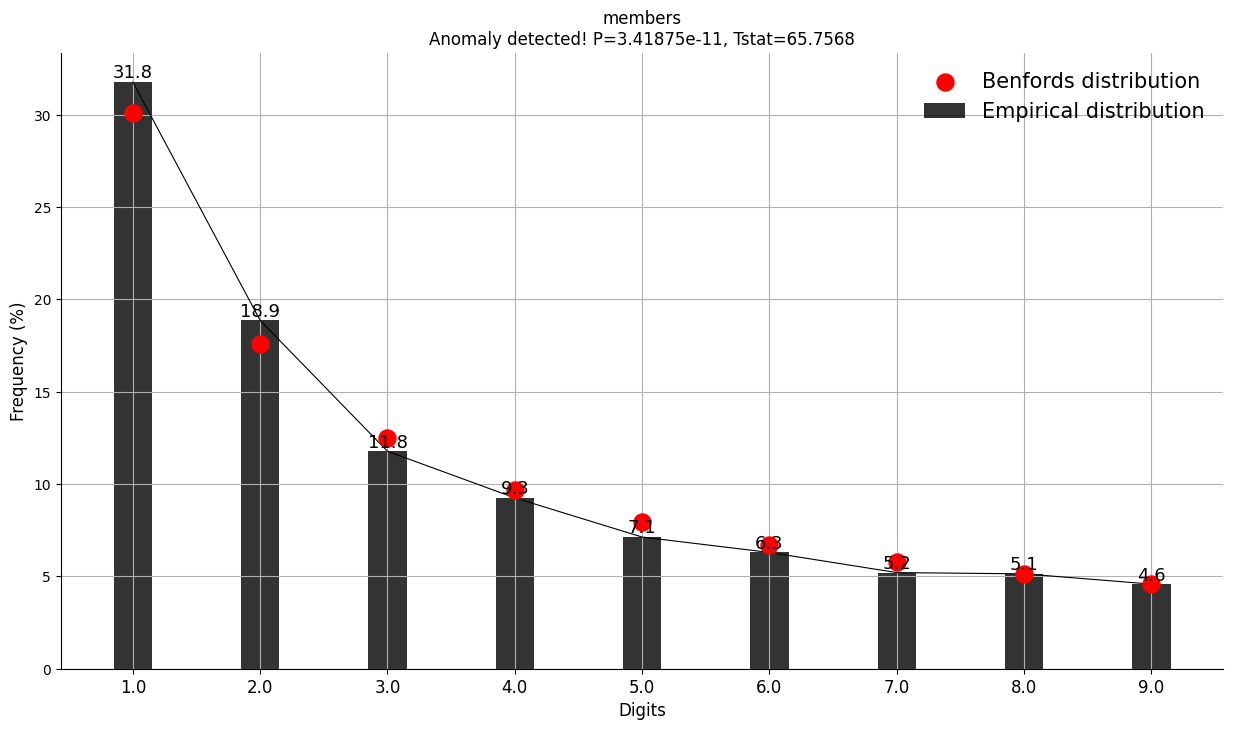

In [42]:
Benford_law (anime_1_no_duplicate,'members')

In [43]:
final_anime_1 = anime_1_no_duplicate.copy()
final_anime_1.to_csv('final_anime_1.csv')

## Profile

In [44]:
profile_no_duplicate = strip(profile)
profile_no_duplicate = lowerCase(profile_no_duplicate)
profile_no_duplicate = profile.drop_duplicates(keep='first')

In [45]:
profile_no_duplicate.loc[profile_no_duplicate['link'] == 'https://myanimelist.net/profile/salad']

,profile,gender,birthday,favorites_anime,link
27212,salad,male,NaN,"['35180', '7785', '9969', '387', '11665', '238...",https://myanimelist.net/profile/salad


For all dataframe, the pandas profiling is applied for the second time, after the duplications are dropped.

In [ ]:
profile_no_duplicate.to_csv('profile_no_duplicate.csv')
ProfileReport(profile_no_duplicate).to_file(output_file='profile_no_duplicate')

Pandas profiling shows that 99.9% of *profile* values are distinct. Since the websites such as **IMDb** and **MyAnimeList** do not allow duplicated profile names, it is necessary to know why this number is not 100.

In [46]:
profile_no_duplicate['profile'].value_counts()

wumbo_combo         2
mksteel             2
nishizawamihashi    2
treas0n             2
midget_king         2
                   ..
v1nn13z             1
megafish0527        1
greatwhiteweeb      1
hippe0              1
srry4apologizng     1
Name: profile, Length: 47885, dtype: int64

In [47]:
set(profile_no_duplicate.loc[profile_no_duplicate['profile'] == 'mksteel']['favorites_anime'])

{"['3090', '880', '304', '10162', '59', '5678', '690', '21877', '50', '477']",
 "['3090', '880', '304', '10162', '59', '5678', '690', '3297', '50', '477']"}

The problem is favorite anime which is probably has been updated based on the user's page but the previous row was not deleted.

In [48]:
profile_no_duplicate = profile_no_duplicate.drop_duplicates(subset=['profile', 'gender', 'birthday',
                                                                    'link'], keep='last').reset_index()

profile_no_duplicate = profile_no_duplicate.drop(labels=['index'], axis=1)

In [49]:
profile_no_duplicate['profile'].value_counts()

chikachibichi      2
desolatepsyche     1
selena54234        1
nocount            1
kid_at_hart        1
                  ..
hippe0             1
leifaleifa         1
kreo20048          1
grymdylan          1
srry4apologizng    1
Name: profile, Length: 47885, dtype: int64

In [50]:
profile_no_duplicate.loc[profile_no_duplicate['profile'] == 'chikachibichi']

,profile,gender,birthday,favorites_anime,link
973,chikachibichi,female,"jun 12, 1998","['1575', '34822', '2924', '11061', '2001', '23...",https://myanimelist.net/profile/chikachibichi
26925,chikachibichi,female,"jun 29, 1998","['1575', '34822', '2924', '11061', '2001', '23...",https://myanimelist.net/profile/chikachibichi


This profile has two different birthdays. Clearly one is wrong so it will be deleted.

In [51]:
profile_no_duplicate = profile_no_duplicate.drop(profile_no_duplicate[profile_no_duplicate.birthday ==
                          'jun 12, 1998'].index)

In [ ]:
ProfileReport(profile_no_duplicate).to_file(output_file='profile_no_duplicate')
profile_no_duplicate.to_csv('profile_no_duplicate.csv')

The results of pandas profiling shows that *profile* is a key candidate. Taking into the consideration the meaning of profile and how it is handled in websites, we can accept it as a key.

In [52]:
# to convert from string to datetime
profile_no_duplicate['birthday'] = pd.to_datetime(
    profile_no_duplicate['birthday'], errors='coerce')
profile_no_duplicate['birthday'] = profile_no_duplicate['birthday'].dt.to_period(
    'M')

In [53]:
profile_no_duplicate.rename(columns={'favorites_anime': 'favAnime'}, inplace=True)
profile_no_duplicate = separation(profile_no_duplicate, 'favAnime')

In [54]:
profile_no_duplicate = profile_no_duplicate.reset_index()
profile_no_duplicate.head(2)

,index,profile,gender,birthday,favAnime,link,favAnime1,favAnime2,favAnime3,favAnime4,...,favAnime11,favAnime12,favAnime13,favAnime14,favAnime15,favAnime16,favAnime17,favAnime18,favAnime19,favAnime20
0,0,desolatepsyche,male,1994-10,"['33352', '25013', '5530', '33674', '1482', '2...",https://myanimelist.net/profile/desolatepsyche,33352,25013,5530,33674,...,12291,226,28851,8525,6594,4981,1698,457,235,34618
1,1,baekbeans,female,2000-11,"['11061', '31964', '853', '20583', '918', '925...",https://myanimelist.net/profile/baekbeans,11061,31964,853,20583,...,None,None,None,None,None,None,None,None,None,None


In [55]:
profile_no_duplicate = profile_no_duplicate.drop(
    labels=['index', 'favAnime'], axis=1)

In [56]:
# If string starts with '-', it causes problems in csv file
for i in range(0,profile_no_duplicate.shape[0]):
    if profile_no_duplicate['profile'][i][0] == '-':
        profile_no_duplicate['profile'][i] = '_' + profile_no_duplicate['profile'][i][1:]


In [57]:
profile_no_duplicate.loc[profile_no_duplicate['link'] == 'https://myanimelist.net/profile/-yukino']

,profile,gender,birthday,link,favAnime1,favAnime2,favAnime3,favAnime4,favAnime5,favAnime6,...,favAnime11,favAnime12,favAnime13,favAnime14,favAnime15,favAnime16,favAnime17,favAnime18,favAnime19,favAnime20
1885,_yukino,female,NaT,https://myanimelist.net/profile/-yukino,18897,30015,38000,35790,23847,36474,...,None,None,None,None,None,None,None,None,None,None


In [58]:
final_profile = profile_no_duplicate.copy()
final_profile.to_csv('final_profile.csv')

In [59]:
final_profile['profile'].value_counts()

desolatepsyche     1
maskdupants        1
diem4eva           1
nocount            1
kid_at_hart        1
                  ..
kreo20048          1
grymdylan          1
koutafromfb        1
laethas            1
srry4apologizng    1
Name: profile, Length: 47877, dtype: int64

## review
The values of *text* column seem unsual thus we take a closer look????????????

In [60]:
review_no_duplicate = strip(review)
review_no_duplicate = lowerCase(review_no_duplicate)
review_no_duplicate = review.drop_duplicates(keep='first')
ProfileReport(review_no_duplicate).to_file(output_file='review_no_duplicate')
review_no_duplicate.to_csv('review_no_duplicate.csv')

In [61]:
review_no_duplicate.head(2)

,uid,profile,anime_uid,score,scores,link
0,255938,desolatepsyche,34096,8,"{'overall': '8', 'story': '8', 'animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,10,"{'overall': '10', 'story': '10', 'animation': ...",https://myanimelist.net/reviews.php?id=259117


In [62]:
review_no_duplicate = review_no_duplicate.reset_index()
review_no_duplicate = review_no_duplicate.drop(labels='index',axis=1)

The values of column *scores* are dictionries so a different approach is needed to separate them. But, first the null values need to be filled with empty dictionary.

In [63]:
# otherwise the next line won't work
review_no_duplicate['scores'] = review_no_duplicate['scores'].fillna('{}')

# because the scores column is a dictionary we use this to separate it
review_no_duplicate['scores'] = review_no_duplicate['scores'].apply(literal_eval)

review_no_duplicate = review_no_duplicate.join(
    pd.json_normalize(review_no_duplicate.pop('scores')))

In [64]:
review_no_duplicate.head(2)

,uid,profile,anime_uid,score,link,overall,story,animation,sound,character,enjoyment
0,255938,desolatepsyche,34096,8,https://myanimelist.net/reviews.php?id=255938,8,8,8,10,9,8
1,259117,baekbeans,34599,10,https://myanimelist.net/reviews.php?id=259117,10,10,10,10,10,10


Since the separated values are scores, they will be converted to integer.

In [65]:
review_no_duplicate['overall'] = review_no_duplicate['overall'].astype(int)
review_no_duplicate['story'] = review_no_duplicate['story'].astype(int)
review_no_duplicate['animation'] = review_no_duplicate['animation'].astype(int)
review_no_duplicate['sound'] = review_no_duplicate['sound'].astype(int)
review_no_duplicate['character'] = review_no_duplicate['character'].astype(int)
review_no_duplicate['enjoyment'] = review_no_duplicate['enjoyment'].astype(int)

The values of *score* in each row, need to be the same as corresponding *overal*.

In [66]:
review_no_duplicate.loc[review_no_duplicate['score'] != review_no_duplicate['overall']]

,uid,profile,anime_uid,score,link,overall,story,animation,sound,character,enjoyment


In [67]:
review_no_duplicate = review_no_duplicate.drop(labels='score',axis=1)

In [68]:
# If string starts with '-', it causes problems in csv file
for i in range(0, review_no_duplicate.shape[0]):
    if review_no_duplicate['profile'][i][0] == '-':
        review_no_duplicate['profile'][i] = '_' + \
            review_no_duplicate['profile'][i][1:]


In [69]:
final_review = review_no_duplicate.copy()
final_review.to_csv('final_review.csv')

## anime_2

In [70]:
anime_2_no_duplicate = strip(anime_2)
anime_2_no_duplicate = lowerCase(anime_2_no_duplicate)

According to the results of pandas profiling, there are no duplicated rows in *anime_2* dataset but the column *name* has 99.9% distinct values. Since this percentage is very close to 100, there is a chance that *name* could be a key thus we analyze why this number is not 100.


In [71]:
anime_2_no_duplicate['name'].value_counts()

maou gakuin no futekigousha: shijou saikyou no maou no shiso, tensei shite shison-tachi no gakkou e    3
hinamatsuri                                                                                            2
youkoso! ecolo shima                                                                                   2
uchuu neko: mardock no bouken                                                                          1
washimo 4th season                                                                                     1
                                                                                                      ..
bucchigiri                                                                                             1
super speed                                                                                            1
tegami bachi: omakebachi                                                                               1
kami nomi zo shiru sekai: flag 0                       

In [72]:
anime_2_no_duplicate.loc[anime_2_no_duplicate['name'] ==
    'maou gakuin no futekigousha: shijou saikyou no maou no shiso, tensei shite shison-tachi no gakkou e']

,mal_id,name,score,genres,english name,type,episodes,aired,premiered,producers,...,score-10,score-9,score-8,score-7,score-6,score-5,score-4,score-3,score-2,score-1
16195,40496,maou gakuin no futekigousha: shijou saikyou no...,7.34,"action, demons, magic, fantasy, school",the misfit of demon king academy,tv,13,"jul 4, 2020 to sep 26, 2020",summer 2020,"aniplex, kadokawa",...,18424.0,23990.0,50133.0,58622.0,27479.0,12119.0,5087.0,2364.0,1209.0,835.0
17543,48417,maou gakuin no futekigousha: shijou saikyou no...,unknown,"magic, fantasy, school",unknown,tv,unknown,unknown,unknown,aniplex,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
17544,48418,maou gakuin no futekigousha: shijou saikyou no...,unknown,"action, demons, magic, fantasy, school",unknown,tv,unknown,unknown,unknown,aniplex,...,1.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown


In [73]:
anime_2_no_duplicate.loc[anime_2_no_duplicate['name'] == 'hinamatsuri']

,mal_id,name,score,genres,english name,type,episodes,aired,premiered,producers,...,score-10,score-9,score-8,score-7,score-6,score-5,score-4,score-3,score-2,score-1
12826,35102,hinamatsuri,6.79,"historical, kids",unknown,ova,1,unknown,unknown,unknown,...,22.0,18.0,38.0,58.0,21.0,12.0,6.0,4.0,1.0,5.0
13540,36296,hinamatsuri,8.21,"comedy, sci-fi, seinen, slice of life, superna...",hinamatsuri,tv,12,"apr 6, 2018 to jun 22, 2018",spring 2018,"media factory, magic capsule, nippon columbia,...",...,21484.0,49894.0,63480.0,29442.0,8408.0,2895.0,813.0,267.0,124.0,168.0


In [74]:
anime_2_no_duplicate['name'] = np.where(anime_2_no_duplicate['mal_id'] == 35102, 'hinamatsuri1993',
                                        anime_2_no_duplicate['name'])


In [75]:
anime_2_no_duplicate.loc[anime_2_no_duplicate['name'] == 'youkoso! ecolo shima']

,mal_id,name,score,genres,english name,type,episodes,aired,premiered,producers,...,score-10,score-9,score-8,score-7,score-6,score-5,score-4,score-3,score-2,score-1
12955,35279,youkoso! ecolo shima,unknown,kids,unknown,ova,1,unknown,unknown,unknown,...,4.0,unknown,unknown,4.0,2.0,2.0,unknown,unknown,unknown,4.0
15379,39143,youkoso! ecolo shima,unknown,kids,unknown,ova,1,unknown,unknown,unknown,...,2.0,unknown,unknown,1.0,2.0,unknown,1.0,unknown,unknown,2.0


This comparision shows that the names of animes are not the ideal candidate for key because there are different type (movie or TV or OVA) of animes with same name. Alos, sometimes one anime will be re-produced with same name in later yaers. However, the lack of null values and high percentage of uniqueness, make them the best candidate available for key. The combination of name, type and year could be another ideal candidate for key but lookung at all the sources, we can see many null values in year and type column.

In [76]:
anime_2_no_duplicate = anime_2_no_duplicate.drop_duplicates(subset=['name', 'type'], keep='last')

In [77]:
anime_2_no_duplicate.rename(columns={'genres':'genre'},inplace=True)
anime_2_no_duplicate = sort_cell(anime_2_no_duplicate, 'genre','mal_id')

In [78]:
anime_2_no_duplicate.loc[anime_2_no_duplicate['name'] == 'papa datte, shitai']['genre']

15134    shounenai
Name: genre, dtype: object

In [79]:
anime_2_no_duplicate['genre'] = anime_2_no_duplicate['genre'].str.replace('shoujo ai', 'Shoujoai')
anime_2_no_duplicate['genre'] = anime_2_no_duplicate['genre'].str.replace('shounen ai', 'Shounenai')
anime_2_no_duplicate['genre'] = anime_2_no_duplicate['genre'].str.replace('shoujoai', 'Shoujoai')
anime_2_no_duplicate['genre'] = anime_2_no_duplicate['genre'].str.replace('shounenai', 'Shounenai')
anime_2_no_duplicate['genre'] = anime_2_no_duplicate['genre'].str.replace('shoujo', 'shojo')
anime_2_no_duplicate['genre'] = anime_2_no_duplicate['genre'].str.replace('shounen', 'shonen')

In [80]:
anime_2_no_duplicate = extract_demographic(anime_2_no_duplicate,'genre')

In [81]:
# These two lines are necessary for separation function to work
anime_2_no_duplicate['genre'] = anime_2_no_duplicate['genre'].replace('',' ')
anime_2_no_duplicate['genre'] = anime_2_no_duplicate['genre'].str.replace(',,,', ',')
anime_2_no_duplicate['genre'] = anime_2_no_duplicate['genre'].str.replace(',,', ',')

In [82]:
anime_2_no_duplicate = separation(anime_2_no_duplicate,'genre')
anime_2_no_duplicate.iloc[1:5,32:]

,score-1,genre,demographic,demographic1,demographic2,demographic3,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genre11,genre12
1,379.0,"action,drama,mystery,sci-fi,space",,None,None,None,action,drama,mystery,sci-fi,space,None,None,None,None,None,None,None
2,533.0,"action,adventure,comedy,drama,sci-fi,",shonen,shonen,None,None,action,adventure,comedy,drama,sci-fi,,None,None,None,None,None,None
3,131.0,"action,drama,magic,mystery,police,supernatural",,None,None,None,action,drama,magic,mystery,police,supernatural,None,None,None,None,None,None
4,27.0,"adventure,fantasy,supernatural",shonen,shonen,None,None,adventure,fantasy,supernatural,None,None,None,None,None,None,None,None,None


In [83]:
anime_2_no_duplicate['demographic3'].unique()

array([None, 'shonen', 'seinen', 'yaoi', 'mecha', 'yuri', 'Shoujoai'],
      dtype=object)

In [84]:
anime_2_no_duplicate[['first_aired', 'last_aired']
                     ] = anime_2_no_duplicate['aired'].str.split(pat=" to ", expand=True)

Certain values that imply null value such as *?* and *unknown* are replaced with null.

In [85]:
anime_2_no_duplicate['first_aired'] = anime_2_no_duplicate['first_aired'].replace({'unknown': None})
anime_2_no_duplicate['last_aired'] = anime_2_no_duplicate['last_aired'].replace({'unknown': None})
anime_2_no_duplicate['first_aired'] = anime_2_no_duplicate['first_aired'].replace({'?': None})
anime_2_no_duplicate['last_aired'] = anime_2_no_duplicate['last_aired'].replace({'?': None})

In [86]:
anime_2_no_duplicate.iloc[1:5,48:]

,genre11,genre12,first_aired,last_aired
1,None,None,"sep 1, 2001",None
2,None,None,"apr 1, 1998","sep 30, 1998"
3,None,None,"jul 2, 2002","dec 24, 2002"
4,None,None,"sep 30, 2004","sep 29, 2005"


In [87]:
'?' in set(anime_2_no_duplicate['last_aired'].unique())

False

The *Premiered* column has values such as *spring* and *summer* which prevent changing the type of column into datetime therefore they are removed

In [88]:
anime_2_no_duplicate['first_aired'] = anime_2_no_duplicate.first_aired.apply(parse_date)
anime_2_no_duplicate['last_aired'] = anime_2_no_duplicate['last_aired'].apply(parse_date)

anime_2_no_duplicate['premiered'] = anime_2_no_duplicate['premiered'].str.replace("spring", '')
anime_2_no_duplicate['premiered'] = anime_2_no_duplicate['premiered'].str.replace("summer", '')
anime_2_no_duplicate['premiered'] = anime_2_no_duplicate['premiered'].str.replace("fall", '')
anime_2_no_duplicate['premiered'] = anime_2_no_duplicate['premiered'].str.replace("winter", '')

anime_2_no_duplicate['premiered'] = anime_2_no_duplicate['premiered'].replace({'unknown': None})
anime_2_no_duplicate['premiered'] = anime_2_no_duplicate['premiered'].apply(parse_date)

In [89]:
anime_2_no_duplicate['first_aired'] = anime_2_no_duplicate['first_aired'].dt.to_period('M')
anime_2_no_duplicate['last_aired'] = anime_2_no_duplicate['last_aired'].dt.to_period('M')
anime_2_no_duplicate['premiered'] = anime_2_no_duplicate['premiered'].dt.to_period('M')

In [90]:
anime_2_no_duplicate.head(2)

,mal_id,name,score,english name,type,episodes,aired,premiered,producers,licensors,...,genre5,genre6,genre7,genre8,genre9,genre10,genre11,genre12,first_aired,last_aired
0,1,cowboy bebop,8.78,cowboy bebop,tv,26,"apr 3, 1998 to apr 24, 1999",1998-02,bandai visual,"funimation, bandai entertainment",...,sci-fi,space,None,None,None,None,None,None,1998-04,1999-04
1,5,cowboy bebop: tengoku no tobira,8.39,cowboy bebop:the movie,movie,1,"sep 1, 2001",NaT,"sunrise, bandai visual",sony pictures entertainment,...,space,None,None,None,None,None,None,None,2001-09,NaT


In [91]:
# These columns are need to be separated too
anime_2_no_duplicate.rename(columns={'producers': 'producer'}, inplace=True)
anime_2_no_duplicate = sort_cell(anime_2_no_duplicate, 'producer', 'mal_id')
anime_2_no_duplicate = separation(anime_2_no_duplicate, 'producer')

anime_2_no_duplicate.rename(columns={'licensors': 'licensor'}, inplace=True)
anime_2_no_duplicate = sort_cell(anime_2_no_duplicate, 'licensor', 'mal_id')
anime_2_no_duplicate = separation(anime_2_no_duplicate, 'licensor')

anime_2_no_duplicate.rename(columns={'studios': 'studio'}, inplace=True)
anime_2_no_duplicate = sort_cell(anime_2_no_duplicate, 'studio', 'mal_id')
anime_2_no_duplicate = separation(anime_2_no_duplicate, 'studio')


In [92]:
studio_list = ['studio1','studio2','studio3','studio4','studio5','studio6','studio7']
for s in studio_list:
    anime_2_no_duplicate[s] = anime_2_no_duplicate[s].str.replace('studio', '')
    anime_2_no_duplicate[s] = anime_2_no_duplicate[s].replace({'unknown': None})

In [93]:
anime_2_no_duplicate['rating'] = anime_2_no_duplicate['rating'].replace({'unknown': None})

The column *Rating* shows the age restriction and the reason/meaning behind it. It is splited into two columns: *age_restriction* and *meaning*

In [94]:
anime_2_no_duplicate[['age_restriction', 'meaning']
                     ] = anime_2_no_duplicate['rating'].str.split(pat=" - ", expand=True)


In [95]:
'unknown' in set(anime_2_no_duplicate['watching'].unique())

False

The column *score-i* means how many people gave the rating i (a number between 1 and 10) to the anime. To clean this column, the unknown values are replaced by null and the type is converted to Int32 so it takes less space compared to Int64.

In [96]:
scores = ['score-10', 'score-9', 'score-8', 'score-7', 'score-6', 'score-5',
          'score-4', 'score-3', 'score-2', 'score-1']
for score_column in scores:
    anime_2_no_duplicate[score_column] = anime_2_no_duplicate[score_column].replace({
                                                                                    'unknown': np.nan})
    anime_2_no_duplicate[score_column] = anime_2_no_duplicate[score_column].astype(
        'float')
    anime_2_no_duplicate[score_column] = anime_2_no_duplicate[score_column].astype(
        'Int32')

[benfordslaw] >Analyzing digit position: [1]
[benfordslaw] >[chi2] Anomaly detected! P=0.00467734, Tstat=22.1319


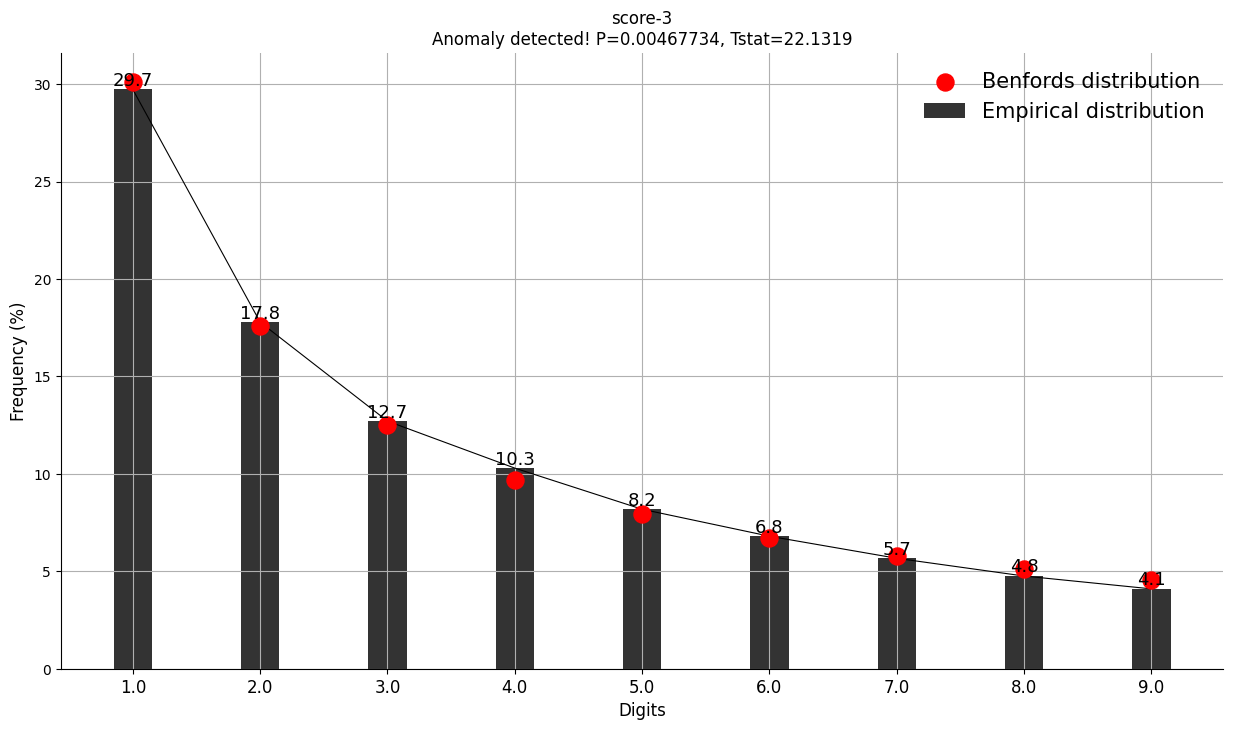

In [97]:
Benford_law(anime_2_no_duplicate,'score-3')

In [98]:
anime_2_no_duplicate = anime_2_no_duplicate.drop(labels=['genre', 'aired', 'producer',
                                                         'licensor', 'studio', 'rating',
                                                         'demographic'], axis=1)


In [99]:
# "unknown" values are replced by null
anime_2_no_duplicate['episodes'] = anime_2_no_duplicate['episodes'].replace({'unknown': np.nan})
anime_2_no_duplicate['type'] = anime_2_no_duplicate['type'].replace({'unknown': None})

In [100]:
anime_2_no_duplicate['episodes'] = anime_2_no_duplicate['episodes'].astype(float)

In [101]:
final_anime_2 = anime_2_no_duplicate.copy()
final_anime_2.to_csv('final_anime_2.csv')

In [ ]:
final_anime_2 = pd.read_csv('final_anime_2.csv')
ProfileReport(final_anime_2).to_file(output_file='final_anime_2')

## anime_3

Similar to *anime_2* dataset, there is no duplicate in this dataset and the column *Name* is not 100% distinct.

In [102]:
anime_3_no_duplicate = anime_3.copy()
anime_3_no_duplicate = strip(anime_3_no_duplicate)
anime_3_no_duplicate = lowerCase(anime_3_no_duplicate)

In [103]:
# check to see whther it is the avg of scores in anime_2: anime_3_no_duplicate['Score']

anime_3_no_duplicate['score'] = anime_3_no_duplicate['score'].replace({'unknown': np.nan})
anime_3_no_duplicate['score'] = anime_3_no_duplicate['score'].astype('float')

In [104]:
anime_3_no_duplicate.rename(columns={'genres':'genre'},inplace=True)
anime_3_no_duplicate = sort_cell(anime_3_no_duplicate, 'genre','mal_id')

In [105]:
anime_3_no_duplicate['genre'] = anime_3_no_duplicate['genre'].str.replace('shoujo ai', 'Shoujoai')
anime_3_no_duplicate['genre'] = anime_3_no_duplicate['genre'].str.replace('shounen ai', 'Shounenai')
anime_3_no_duplicate['genre'] = anime_3_no_duplicate['genre'].str.replace('shoujoai', 'Shoujoai')
anime_3_no_duplicate['genre'] = anime_3_no_duplicate['genre'].str.replace('shounenai', 'Shounenai')
anime_3_no_duplicate['genre'] = anime_3_no_duplicate['genre'].str.replace('shoujo', 'shojo')
anime_3_no_duplicate['genre'] = anime_3_no_duplicate['genre'].str.replace('shounen', 'shonen')

In [106]:
anime_3_no_duplicate = extract_demographic(anime_3_no_duplicate,'genre')

In [107]:
anime_3_no_duplicate['genre'] = anime_3_no_duplicate['genre'].replace('',' ')
anime_3_no_duplicate['genre'] = anime_3_no_duplicate['genre'].str.replace(',,,', ',')
anime_3_no_duplicate['genre'] = anime_3_no_duplicate['genre'].str.replace(',,', ',')

anime_3_no_duplicate = separation(anime_3_no_duplicate,'genre')

Synopsis is a summary of the anime. The data profiling tools show that a high percentage of this column's values are distinct. Considering the nature of *sypnopsis* column (which is misspelled), it is not illogical to believe that it could be a key therefore, we take a closer look at its values.

In [110]:
anime_3_no_duplicate.rename(columns={'sypnopsis':'synopsis'},inplace=True)

In [111]:
anime_3_no_duplicate['synopsis'].value_counts()

no synopsis information has been added to this title. help improve our database by adding a synopsis here .                                                                                                                                                                                                                                                                                                                                                                                                                                                   709
no synopsis has been added for this series yet. click here to update this information.                                                                                                                                                                                                                                                                                                                                                                                

There are two values in this column that represent the null value:
- *No synopsis information has been added to this title. Help improve our database by adding a synopsis here .*
- *No synopsis has been added for this series yet. Click here to update this information.*
Both will be replaced by null.

In [112]:
anime_3_no_duplicate['synopsis'] = anime_3_no_duplicate['synopsis'].replace(
    {'no synopsis information has been added to this title. help improve our database by adding a synopsis here .': None})


# none or unknown??
anime_3_no_duplicate['synopsis'] = anime_3_no_duplicate['synopsis'].replace(
    {'no synopsis has been added for this series yet. click here to update this information.': None})



Values such as "*Film by Takashi Ito.*" are not techniqually sypnopsis but their existance prevent us from considering *sypnopsis* a key candidate.

In [113]:
anime_3_no_duplicate.head(2)

,mal_id,name,score,synopsis,genre,demographic,demographic1,demographic2,demographic3,genre1,...,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genre11,genre12
0,1,cowboy bebop,8.78,"in the year 2071, humanity has colonized sever...","action,adventure,comedy,drama,sci-fi,space",,None,None,None,action,...,comedy,drama,sci-fi,space,None,None,None,None,None,None
1,5,cowboy bebop: tengoku no tobira,8.39,"other day, another bounty—such is the life of ...","action,drama,mystery,sci-fi,space",,None,None,None,action,...,mystery,sci-fi,space,None,None,None,None,None,None,None


In [114]:
anime_3_no_duplicate = anime_3_no_duplicate.drop(labels=['genre','demographic'],axis=1)

In [115]:
final_anime_3 = anime_3_no_duplicate.copy()
final_anime_3.to_csv('final_anime_3.csv')

## watching_status

Both columns in this table are 100% distinct meaning they are unique and acceptable candidates for key.

In [116]:
watching_status = strip(watching_status)
watching_status = lowerCase(watching_status)

In [117]:
final_watching_status = watching_status.copy()
final_watching_status.to_csv('final_watching_status.csv')

## anime_4

In [118]:
# one duplicated row
anime_4_no_duplicate = strip(anime_4)
anime_4_no_duplicate = lowerCase(anime_4_no_duplicate)
anime_4_no_duplicate = anime_4_no_duplicate.drop_duplicates(keep='first')
anime_4_no_duplicate.head(2)

,name,type,score,score rank,popularity rank,air date,studio,num. of episodes,genres,theme(s),demographic
0,fullmetal alchemist: brotherhood,tv,9.14,1,3,"apr 5, 2009 to jul 4, 2010",['bones'],64,"['action', 'adventure', 'drama', 'fantasy']",['military'],shounen
1,spy x family,tv,9.09,2,350,"apr 9, 2022 to ?","['wit studio', ' cloverworks']",12,"['action', 'comedy']",['childcare'],shounen


In [119]:
anime_4_no_duplicate[['first_aired', 'last_aired']
                     ] = anime_4_no_duplicate['air date'].str.split(pat=" to ", expand=True)
anime_4_no_duplicate['first_aired'] = pd.to_datetime(
    anime_4_no_duplicate['first_aired'], errors='coerce')
anime_4_no_duplicate['last_aired'] = pd.to_datetime(
    anime_4_no_duplicate['last_aired'], errors='coerce')

In [120]:
# for this "name" is pk
anime_4_no_duplicate = sort_cell(anime_4_no_duplicate, 'studio','name')
anime_4_no_duplicate = separation(anime_4_no_duplicate, 'studio')

anime_4_no_duplicate.rename(columns={'theme(s)':'theme'},inplace=True)
anime_4_no_duplicate = sort_cell(anime_4_no_duplicate, 'theme','name')
anime_4_no_duplicate = separation(anime_4_no_duplicate,'theme')

In [121]:
anime_4_no_duplicate.rename(columns={'genres':'genre'},inplace=True)
anime_4_no_duplicate = sort_cell(anime_4_no_duplicate, 'genre','name')
anime_4_no_duplicate = separation(anime_4_no_duplicate,'genre')

It is unclear what column *theme* indicates, thus matching algorithm is used to clarify the idea behind it. Considering the meaning of the word "theme", the matching will be done between this column and columns *genre* and *demographic*.

In [122]:
genre_set = set()
demographic_set = set()
DFs = [final_anime_1, final_anime_2, final_anime_3]
for df in DFs:
    for c in list(df.columns):
        if 'genre' in c:
            # This set has all unique values of genre columns
            genre_set = genre_set.union(set(df[c].unique()))
        elif 'demographic' in c:
            # This set has all unique values of demographic columns
            demographic_set = demographic_set.union(set(df[c].unique()))


In [123]:
theme_set = set()
for c in list(anime_4_no_duplicate.columns):
    if 'theme' == c:
        pass
    elif 'theme' in c:
        theme_set = theme_set.union(set(anime_4_no_duplicate[c].unique()))


In [124]:
genre_set.remove(None)
demographic_set.remove(None)
theme_set.remove(None)

In [127]:
genre_theme_similarity = []
for genre in genre_set:
    for theme in theme_set:
        similarity = SequenceMatcher(None, genre, theme)
        similarity_ratio = similarity.ratio()

        if (similarity_ratio > 0.65) & (similarity_ratio < 1):
            gts = [genre,theme,similarity_ratio]
            genre_theme_similarity.append(gts)

genre_theme_similarity_df = pd.DataFrame(genre_theme_similarity, columns=[
                                         'Genre', 'Theme', 'similarity'])
genre_theme_similarity_df

,Genre,Theme,similarity
0,sports,teamsports,0.750000
1,sports,combatsports,0.666667
2,action,racing,0.666667
3,martialarts,visualarts,0.666667


In [128]:
demographic_theme_similarity = []
for demographic in demographic_set:
    for theme in theme_set:
        similarity = SequenceMatcher(None, demographic, theme)
        similarity_ratio = similarity.ratio()

        if (similarity_ratio > 0.60) & (similarity_ratio < 1):
            gts = [demographic,theme,similarity_ratio]
            demographic_theme_similarity.append(gts)

demographic_theme_similarity_df = pd.DataFrame(demographic_theme_similarity, columns=[
                                         'Demographic', 'Theme', 'similarity'])
demographic_theme_similarity_df

,Demographic,Theme,similarity
0,shoujoai,mahoushoujo,0.631579
1,shojo,mahoushoujo,0.625000
2,shojo,school,0.727273
3,mecha,medical,0.666667


The similarities show that the column "theme" contains genres and demographic thus it is redundant so we drop it.

In [129]:
anime_4_no_duplicate['demographic'].unique()

array(['shounen', 'none', 'shoujo', 'seinen', 'josei', 'kids'],
      dtype=object)

In [130]:
anime_4_no_duplicate['demographic'] = anime_4_no_duplicate['demographic'].replace({'none': None})
anime_4_no_duplicate['demographic'] = anime_4_no_duplicate['demographic'].replace({'shounen': 'shonen'})
anime_4_no_duplicate['demographic'] = anime_4_no_duplicate['demographic'].replace({'shoujo': 'shojo'})

Among the *Demographic* column's values there is string called none which is replaced by actual null value.

In [131]:
anime_4_no_duplicate['demographic'] = anime_4_no_duplicate['demographic'].replace({'none': None})

In [132]:
anime_4_no_duplicate = anime_4_no_duplicate.drop(
    labels=['studio', 'genre', 'theme'], axis=1)


In [133]:
final_anime_4 = anime_4_no_duplicate.copy()
final_anime_4.to_csv('final_anime_4.csv')

## anime_5

In [134]:
anime_5_no_duplicate = anime_5.copy()
anime_5_no_duplicate = strip(anime_5_no_duplicate)
anime_5_no_duplicate = lowerCase(anime_5_no_duplicate)
anime_5_no_duplicate.head(2)

,rank,title,rating,votes,year,minutes,genre,gross
0,1,ramayana: the legend of prince rama,9.2,"7,549",1993,97.0,"animation, action, adventure",NaN
1,2,spirited away,8.6,"756,112",2001,125.0,"animation, adventure, family",$10.06m


The type of *votes* column is object thus it will be converted to integer because this columns show the number of people who rated this anime on IMDb.

In [135]:
# First we need to remove ","
anime_5_no_duplicate['votes'] = anime_5_no_duplicate['votes'].str.replace(",", '')
anime_5_no_duplicate['votes'] = anime_5_no_duplicate['votes'].astype(int)

In [136]:
anime_5_no_duplicate['year'] = anime_5_no_duplicate['year'].astype('int32')

In [137]:
anime_5_no_duplicate = sort_cell(anime_5_no_duplicate,'genre','title')

In [138]:
anime_5_no_duplicate = extract_demographic(anime_5_no_duplicate,'genre')

In [139]:
anime_5_no_duplicate['demographic1'].unique()

array([None], dtype=object)

In [140]:
anime_5_no_duplicate = separation(anime_5_no_duplicate,'genre')

The column gross also needs some additional cleaning steps.

In [141]:
anime_5_no_duplicate['gross'] = anime_5_no_duplicate['gross'].replace({'\$': '', 'm': ''}, regex=True)
anime_5_no_duplicate['gross'] = anime_5_no_duplicate['gross'].astype(float)
anime_5_no_duplicate.rename(columns={'gross': 'gross(M$)'}, inplace=True)

In [142]:
anime_5_no_duplicate = anime_5_no_duplicate.drop(labels=['genre','demographic','demographic1'],axis=1)

In [143]:
final_anime_5 = anime_5_no_duplicate.copy()
final_anime_5.to_csv('final_anime_5.csv')